# Лабораторная работа №2. Создание истории данных
#### Задание:

Выбрать набор данных (датасет), содержащий категориальные и числовые признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.).
Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
1. устранение пропусков в данных;
1. кодирование категориальных признаков;
1. нормализацию числовых признаков.

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders.count import CountEncoder as ce_CountEncoder

In [6]:
data = pd.read_csv('../ds_salaries_damaged.csv', sep=",")
print(data.shape)
data.head()

(3755, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000.0,EUR,85847.0,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000.0,USD,30000.0,NaN,100,US,S
2,2023,MI,CT,ML Engineer,25500.0,USD,25500.0,US,100,US,S
3,2023,SE,FT,Data Scientist,175000.0,USD,175000.0,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000.0,USD,120000.0,CA,100,CA,M


### Обработка пропусков

In [26]:
cols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
[(c, data[c].isnull().sum(), "%.3f" % data[c].isnull().mean()) for c in cols_with_na]

[('salary', 20, '0.005'),
 ('salary_in_usd', 20, '0.005'),
 ('employee_residence', 27, '0.007')]

Обработка пропусков для числовых признаков с помощью KNNImputer

In [40]:
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)

cols_to_impute = ['salary', 'salary_in_usd']
num_data_imputed = data.copy()
num_data_imputed[cols_to_impute] = knnimputer.fit_transform(data[cols_to_impute])

print(num_data_imputed.shape)
[(c, num_data_imputed[c].isnull().sum(), "%.3f" % num_data_imputed[c].isnull().mean()) for c in cols_with_na]

(3755, 11)


[('salary', 0, '0.000'),
 ('salary_in_usd', 0, '0.000'),
 ('employee_residence', 27, '0.007')]

Обработка пропусков для категориального признака с помощью SipleImputer с заполнением пропусков самым популярным значением

In [39]:
simpleimputer = SimpleImputer(
    strategy='most_frequent'
)
cols_to_impute = ['employee_residence']
cat_data_imputed = num_data_imputed.copy()
cat_data_imputed[cols_to_impute] = simpleimputer.fit_transform(data[cols_to_impute])

print(cat_data_imputed.shape)
[(c, cat_data_imputed[c].isnull().sum(), "%.3f" % cat_data_imputed[c].isnull().mean()) for c in cols_with_na]

(3755, 11)


[('salary', 0, '0.000'),
 ('salary_in_usd', 0, '0.000'),
 ('employee_residence', 0, '0.000')]

### Кодирование категориальных признаков методом Count Encoding

In [52]:
print(cat_data_imputed["experience_level"].unique(), '\n')

# Без нормализации
encoder_test = ce_CountEncoder()
col_encoded_test = encoder_test.fit_transform(cat_data_imputed[['experience_level']])
print(col_encoded_test["experience_level"].unique(), '\n')

# С нормализацией
encoder = ce_CountEncoder(normalize=True)
col_encoded = encoder.fit_transform(cat_data_imputed[['experience_level']])
print(col_encoded["experience_level"].unique())

['SE' 'MI' 'EN' 'EX'] 

[2516  805  320  114] 

[0.67003995 0.21438083 0.08521971 0.03035952]


In [46]:
data_encoded = cat_data_imputed.copy()
data_encoded['experience_level'] = col_encoded
data_encoded.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,0.670040,FT,Principal Data Scientist,80000.0,EUR,85847.0,ES,100,ES,L
1,2023,0.214381,CT,ML Engineer,30000.0,USD,30000.0,US,100,US,S
2,2023,0.214381,CT,ML Engineer,25500.0,USD,25500.0,US,100,US,S
3,2023,0.670040,FT,Data Scientist,175000.0,USD,175000.0,CA,100,CA,M
4,2023,0.670040,FT,Data Scientist,120000.0,USD,120000.0,CA,100,CA,M


### Нормализация числовых признаков методом Йео-Джонсона

До преобразования Йео-Джонсона

(array([135., 264., 422., 592., 736., 595., 418., 291., 170.,  54.,  48.,
          9.,   7.,   7.,   3.,   4.]),
 array([  5132.  ,  32936.25,  60740.5 ,  88544.75, 116349.  , 144153.25,
        171957.5 , 199761.75, 227566.  , 255370.25, 283174.5 , 310978.75,
        338783.  , 366587.25, 394391.5 , 422195.75, 450000.  ]),
 <BarContainer object of 16 artists>)

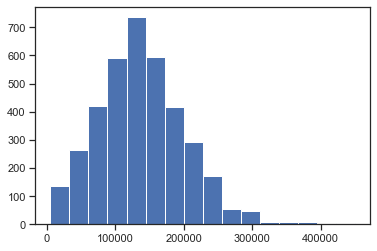

In [55]:
plt.hist(data_encoded['salary_in_usd'], bins=16)

После преобразования Йео-Джонсона

(array([ 59.,  76., 164., 266., 388., 578., 694., 605., 457., 212., 151.,
         65.,  19.,   9.,   6.,   6.]),
 array([  513.68039485,  1177.21680997,  1840.75322509,  2504.28964021,
         3167.82605533,  3831.36247045,  4494.89888557,  5158.43530069,
         5821.97171581,  6485.50813093,  7149.04454605,  7812.58096117,
         8476.1173763 ,  9139.65379142,  9803.19020654, 10466.72662166,
        11130.26303678]),
 <BarContainer object of 16 artists>)

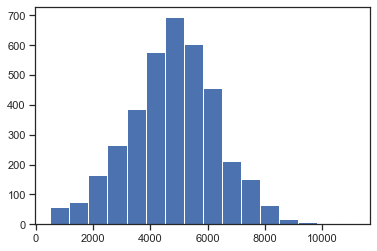

In [56]:
normalized_col, params = stats.yeojohnson(data_encoded['salary_in_usd']) 
plt.hist(normalized_col, bins=16)